In [51]:
#Importing all necessary Libraries
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib_inline
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3, venn3_circles
import locale
from itertools import combinations
from collections import Counter

In [52]:
#Loading Data
sheet_id = '17astDkGsYC-jQQmDux53Wx9ikqDzqFFN59iqn01l2PE'
xl = pd.ExcelFile(f"https://docs.google.com/spreadsheets/d/{sheet_id}/export?format=xlsx")
data = pd.read_excel(xl)
data.head()

,CREATED_DATE,CREATED_DATE minus Hour,USER_ID,TRANSACTION_ID,TYPE,CURRENCY,AMOUNT
0,2016-01-09 00:18:14.422,2016-01-09 00:18:14.422,45e3c222-38ac-4fdb-b092-ff1639e4438c,27d7fd11-d885-4d2c-9ed1-daa89b7bda1d,TOPUP,EUR,177.38
1,2016-01-09 02:28:34.176,2016-01-09 02:28:34.176,57c11728-b979-4856-bada-1d268726cfe9,2e1ee26c-0d24-4931-a7f9-0caa0d07eb2e,BANK_TRANSFER,EUR,310.27
2,2016-01-09 04:00:33.545,2016-01-09 04:00:33.545,1319cca9-02a7-4a15-8abb-48d4e08e5aa3,bfd20e6f-ddb3-4237-bcd2-f7f8d967e36e,CARD_PAYMENT,EUR,96.44
3,2016-01-09 10:26:26.763,2016-01-09 10:26:26.763,3f6bb28c-f945-4027-9178-747956c3ea58,85037186-039a-4ae5-9fea-e87f30822218,BANK_TRANSFER,EUR,288.51
4,2016-01-09 11:37:59.441,2016-01-09 11:37:59.441,f54baeeb-7282-4d23-9bb7-e8396ce1b159,8e1e938a-1916-4d5e-b261-82c61a6979d6,CARD_PAYMENT,GBP,88.45


In [53]:
#getting the summary of overall Data
profile=ProfileReport(data)
profile

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

In [54]:
# getting broader idea about transactions(total No of transactions  done by each currency and each platform )
filtered_data = data[data['CURRENCY'].isin(['EUR', 'GBP'])]


pivot_table = filtered_data.pivot_table(index='TYPE', columns='CURRENCY', values='TRANSACTION_ID', aggfunc='count', fill_value=0)

print("Total Number of Transactions by Type and Currency:")
print(pivot_table)

Total Number of Transactions by Type and Currency:
CURRENCY        EUR   GBP
TYPE                     
ATM            1209  1148
BANK_TRANSFER  1181  1190
CARD_PAYMENT   1147  1178
P2P_TRANSFER    105   469
TOPUP          1209  1164


In [55]:
filtered_data = data[data['CURRENCY'].isin(['EUR', 'GBP'])]


pivot_table = filtered_data.pivot_table(index='CURRENCY', values='AMOUNT', aggfunc='sum')

print("Total Amount by Currency:")
print(pivot_table)

Total Amount by Currency:
             AMOUNT
CURRENCY           
EUR       852363.35
GBP       905319.18


In [56]:
# assuming that the companys who's transactions data we have is India based and EUR, GBP will going to be converted in indian 
#rupee so this code will calculate the total profit we got in indian currency
# 1 GBP = 105 INR and 1 EUR = 90 INR so we can clearly sees,  the profit can be maximize by increasing GBP transactions

filtered_data = data[data['CURRENCY'].isin(['EUR', 'GBP'])]

# Define exchange rates
exchange_rates = {'GBP': 105, 'EUR': 93}

# Define conversion fees for each currency
conversion_fees = {'GBP': {'flat_fee': 0.28, 'percentage_fee': 0.0055},
                   'EUR': {'flat_fee': 0.52, 'percentage_fee': 0.0067}}

# Calculate profit for each currency type
profit_by_currency = {}

for index, row in filtered_data.iterrows():
    currency = row['CURRENCY']
    amount = row['AMOUNT']
    inr_amount = amount * exchange_rates[currency]
    
    flat_fee = conversion_fees[currency]['flat_fee']
    percentage_fee = conversion_fees[currency]['percentage_fee']
    
    total_fee = flat_fee + (percentage_fee * inr_amount)
    profit_inr = inr_amount - total_fee
    
    if currency not in profit_by_currency:
        profit_by_currency[currency] = 0
    profit_by_currency[currency] += profit_inr

print("Total Profit by Currency in INR:")
for currency, profit in profit_by_currency.items():
    print(f"{currency}: {profit:.2f} INR")

Total Profit by Currency in INR:
EUR: 78736161.43 INR
GBP: 94534250.35 INR


In [50]:
# here we calculate to amount collected in each month in indian currency
locale.setlocale(locale.LC_ALL, 'en_IN')


exchange_rates = {'GBP': 105, 'EUR': 93}


conversion_fees = {'GBP': {'flat_fee': 0.28, 'percentage_fee': 0.0055},
                   'EUR': {'flat_fee': 0.52, 'percentage_fee': 0.0067}}




data['Month'] = data['CREATED_DATE'].dt.month
data['Year'] = data['CREATED_DATE'].dt.year


def calculate_profit(row):
    currency = row['CURRENCY']
    amount = row['AMOUNT']
    inr_amount = amount * exchange_rates[currency]
    
    flat_fee = conversion_fees[currency]['flat_fee']
    percentage_fee = conversion_fees[currency]['percentage_fee']
    
    total_fee = flat_fee + (percentage_fee * inr_amount)
    profit_inr = inr_amount - total_fee
    
    return profit_inr


data['Profit_INR'] = data.apply(calculate_profit, axis=1)


monthly_profit = data.groupby(['Year', 'Month', 'CURRENCY'])['Profit_INR'].sum()


for index, profit in monthly_profit.items():
    year, month, currency = index
    formatted_profit = locale.currency(profit, grouping=True)
    print(f"Month: {month:02d}  Year: {year}  Currency: {currency}  Profit: {formatted_profit}")

Month: 01  Year: 2016  Currency: EUR  Profit: ₹ 18,11,958.13
Month: 01  Year: 2016  Currency: GBP  Profit: ₹ 21,04,639.91
Month: 02  Year: 2016  Currency: EUR  Profit: ₹ 20,55,290.71
Month: 02  Year: 2016  Currency: GBP  Profit: ₹ 28,12,822.31
Month: 03  Year: 2016  Currency: EUR  Profit: ₹ 40,73,653.13
Month: 03  Year: 2016  Currency: GBP  Profit: ₹ 47,83,958.95
Month: 04  Year: 2016  Currency: EUR  Profit: ₹ 40,61,148.24
Month: 04  Year: 2016  Currency: GBP  Profit: ₹ 47,24,112.55
Month: 05  Year: 2016  Currency: EUR  Profit: ₹ 45,71,518.12
Month: 05  Year: 2016  Currency: GBP  Profit: ₹ 53,91,309.73
Month: 06  Year: 2016  Currency: EUR  Profit: ₹ 49,84,970.33
Month: 06  Year: 2016  Currency: GBP  Profit: ₹ 60,79,348.67
Month: 07  Year: 2016  Currency: EUR  Profit: ₹ 75,74,265.74
Month: 07  Year: 2016  Currency: GBP  Profit: ₹ 85,90,894.62
Month: 08  Year: 2016  Currency: EUR  Profit: ₹ 93,13,195.14
Month: 08  Year: 2016  Currency: GBP  Profit: ₹ 1,19,71,230.14
Month: 09  Year: 2016 

In [58]:
#here we extract the data of No of transactions done in each month by each currency
filtered_data = data[data['CURRENCY'].isin(['EUR', 'GBP'])]

# Define exchange rates
exchange_rates = {'GBP': 105, 'EUR': 93}

# Convert amounts to INR
filtered_data['INR_AMOUNT'] = filtered_data.apply(lambda row: row['AMOUNT'] * exchange_rates[row['CURRENCY']], axis=1)


filtered_data['Month'] = filtered_data['CREATED_DATE'].dt.month
filtered_data['Year'] = filtered_data['CREATED_DATE'].dt.year


monthly_transaction_count = filtered_data.groupby(['CURRENCY', 'Year', 'Month'])['TRANSACTION_ID'].count()

print("Monthly Transaction Count by Currency:")
print(monthly_transaction_count)

Monthly Transaction Count by Currency:
CURRENCY  Year  Month
EUR       2016  1        103
                2        130
                3        247
                4        236
                5        292
                6        308
                7        467
                8        581
                9        523
                10       574
                11       601
                12       633
          2017  1        156
GBP       2016  1        111
                2        154
                3        273
                4        261
                5        313
                6        320
                7        458
                8        631
                9        557
                10       641
                11       595
                12       653
          2017  1        182
Name: TRANSACTION_ID, dtype: int64


In [59]:
transaction_types = ['P2P_TRANSFER', 'ATM', 'CARD_PAYMENT', 'BANK_TRANSFER', 'TOPUP']


filtered_data = data[data['TYPE'].isin(transaction_types)]


filtered_data['CREATED_DATE'] = pd.to_datetime(filtered_data['CREATED_DATE'])


filtered_data['Month'] = filtered_data['CREATED_DATE'].dt.month
filtered_data['Year'] = filtered_data['CREATED_DATE'].dt.year

monthly_transaction_count = filtered_data.groupby(['TYPE', 'Year', 'Month'])['TRANSACTION_ID'].count()

print("Monthly Transaction Count by Type:")
print(monthly_transaction_count)

Monthly Transaction Count by Type:
TYPE   Year  Month
ATM    2016  1         44
             2         66
             3        116
             4        121
             5        149
                     ... 
TOPUP  2016  9        263
             10       287
             11       267
             12       326
       2017  1         73
Name: TRANSACTION_ID, Length: 65, dtype: int64


In [60]:
# unique users in each month
data['Month'] = data['CREATED_DATE'].dt.month
data['Year'] = data['CREATED_DATE'].dt.year

monthly_unique_users = data.groupby(['Year', 'Month'])['USER_ID'].nunique()

print("Monthly Unique Users:")
print(monthly_unique_users)

Monthly Unique Users:
Year  Month
2016  1         79
      2        105
      3        161
      4        159
      5        189
      6        230
      7        276
      8        338
      9        349
      10       379
      11       388
      12       421
2017  1        160
Name: USER_ID, dtype: int64


In [61]:
transaction_type_amounts = data.groupby('TYPE')['AMOUNT'].sum()

print("Total Amount by Transaction Type:")
print(transaction_type_amounts)

Total Amount by Transaction Type:
TYPE
ATM              411698.70
BANK_TRANSFER    418864.83
CARD_PAYMENT     414852.35
P2P_TRANSFER     101981.34
TOPUP            410285.31
Name: AMOUNT, dtype: float64


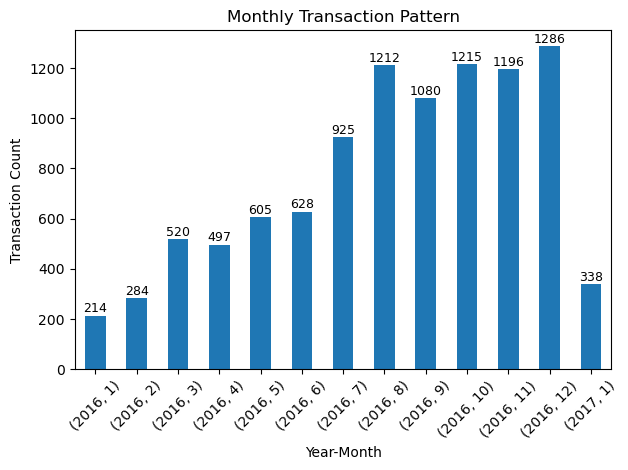

In [63]:
#visualixe the total No of transactions in each month
data['CREATED_DATE'] = pd.to_datetime(data['CREATED_DATE'])
data['Year'] = data['CREATED_DATE'].dt.year
data['Month'] = data['CREATED_DATE'].dt.month


monthly_transaction_count = data.groupby(['Year', 'Month'])['TRANSACTION_ID'].count()


ax = monthly_transaction_count.plot(kind='bar')
plt.xlabel('Year-Month')
plt.ylabel('Transaction Count')
plt.title('Monthly Transaction Pattern')

for i, count in enumerate(monthly_transaction_count):
    ax.text(i, count + 1, str(count), ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [64]:
data.head(10)

,CREATED_DATE,CREATED_DATE minus Hour,USER_ID,TRANSACTION_ID,TYPE,CURRENCY,AMOUNT,Month,Year
0,2016-01-09 00:18:14.422,2016-01-09 00:18:14.422,45e3c222-38ac-4fdb-b092-ff1639e4438c,27d7fd11-d885-4d2c-9ed1-daa89b7bda1d,TOPUP,EUR,177.38,1,2016
1,2016-01-09 02:28:34.176,2016-01-09 02:28:34.176,57c11728-b979-4856-bada-1d268726cfe9,2e1ee26c-0d24-4931-a7f9-0caa0d07eb2e,BANK_TRANSFER,EUR,310.27,1,2016
2,2016-01-09 04:00:33.545,2016-01-09 04:00:33.545,1319cca9-02a7-4a15-8abb-48d4e08e5aa3,bfd20e6f-ddb3-4237-bcd2-f7f8d967e36e,CARD_PAYMENT,EUR,96.44,1,2016
3,2016-01-09 10:26:26.763,2016-01-09 10:26:26.763,3f6bb28c-f945-4027-9178-747956c3ea58,85037186-039a-4ae5-9fea-e87f30822218,BANK_TRANSFER,EUR,288.51,1,2016
4,2016-01-09 11:37:59.441,2016-01-09 11:37:59.441,f54baeeb-7282-4d23-9bb7-e8396ce1b159,8e1e938a-1916-4d5e-b261-82c61a6979d6,CARD_PAYMENT,GBP,88.45,1,2016
5,2016-01-09 12:16:52.201,2016-01-09 12:16:52.201,20100a1d-12bc-41ed-a5e1-bc46216e9696,19931f9b-d87a-411e-9797-57271aead71d,TOPUP,EUR,267.71,1,2016
6,2016-01-09 12:26:36.356,2016-01-09 12:26:36.356,20100a1d-12bc-41ed-a5e1-bc46216e9696,23ba2192-0c73-4d6b-8588-d4f7de3dbfc5,BANK_TRANSFER,GBP,288.25,1,2016
7,2016-01-09 18:02:09.862,2016-01-09 18:02:09.862,2e9e1e2f-e61c-44c3-adb4-4cb6f9c10d5b,5e76d32f-63f7-4e79-a81f-e9acc5b507b4,ATM,GBP,24.85,1,2016
8,2016-01-09 20:26:40.835,2016-01-09 20:26:40.835,86f4e494-3245-4081-9ea8-71dc5fe99b00,f0943b49-44d0-460e-a301-09a312250046,TOPUP,EUR,192.73,1,2016
9,2016-01-09 22:26:16.418,2016-01-09 22:26:16.418,57c11728-b979-4856-bada-1d268726cfe9,02423bf9-55ce-4999-8a4e-b6927a99e482,CARD_PAYMENT,EUR,209.88,1,2016


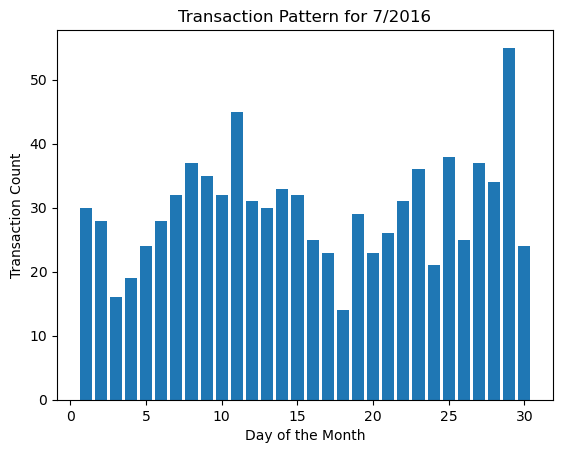

In [40]:
#visualize transction patterns in a particular month
desired_month = 7 
desired_year = 2016


daily_transaction_counts = []


for day in range(1, 31):
    
    desired_date = pd.to_datetime(f"{desired_year}-{desired_month:02d}-{day:02d}").date()
    
    selected_day_data = data[data['CREATED_DATE'].dt.date == desired_date]
    
    daily_transaction_count = len(selected_day_data)
    
    
    daily_transaction_counts.append(daily_transaction_count)

plt.bar(range(1, 31), daily_transaction_counts)
plt.xlabel('Day of the Month')
plt.ylabel('Transaction Count')
plt.title(f'Transaction Pattern for {desired_month}/{desired_year}')
plt.show()


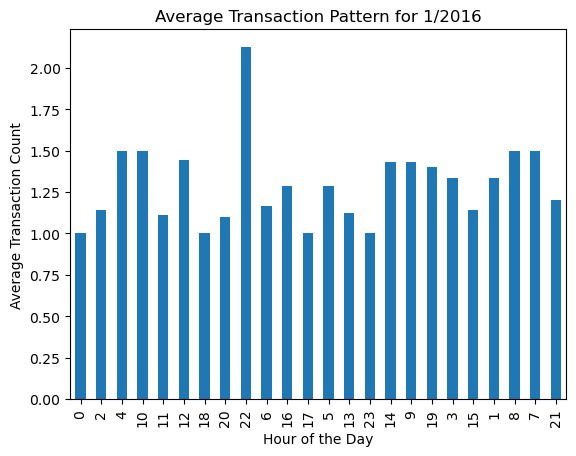

In [41]:
#visualize transction patterns on a particular day
desired_month = 1  
desired_year = 2016


hourly_transaction_counts_per_day = []


for day in range(1, 31):
    
    desired_date = pd.to_datetime(f"{desired_year}-{desired_month:02d}-{day:02d}").date()
    
   
    selected_day_data = data[data['CREATED_DATE'].dt.date == desired_date]
    
   
    hourly_transaction_count = selected_day_data.groupby(selected_day_data['CREATED_DATE'].dt.hour)['TRANSACTION_ID'].count()
    
    
    hourly_transaction_counts_per_day.append(hourly_transaction_count)


hourly_transaction_counts_df = pd.DataFrame(hourly_transaction_counts_per_day)


average_hourly_transaction_count = hourly_transaction_counts_df.mean()


average_hourly_transaction_count.plot(kind='bar')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Transaction Count')
plt.title(f'Average Transaction Pattern for {desired_month}/{desired_year}')
plt.show()

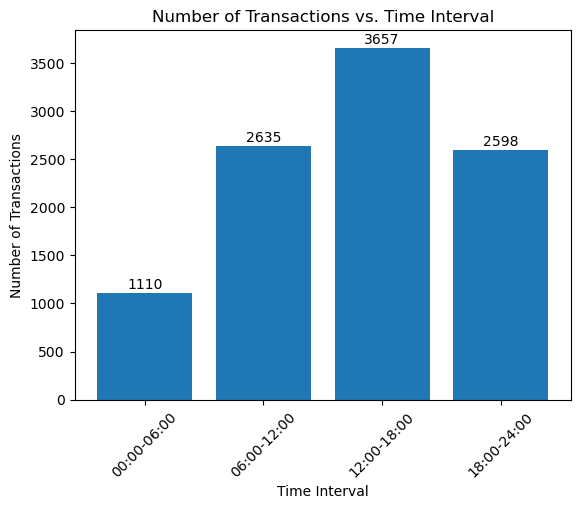

In [65]:
#visualize transction patterns in a time interval of  particular day of a month
data['Hour'] = data['CREATED_DATE'].dt.hour


time_intervals = [(0, 6), (6, 12), (12, 18), (18, 24)]
time_interval_labels = ['00:00-06:00', '06:00-12:00', '12:00-18:00', '18:00-24:00']


transactions_per_interval = []
for interval in time_intervals:
    start_hour, end_hour = interval
    transactions = data[(data['Hour'] >= start_hour) & (data['Hour'] < end_hour)]['TRANSACTION_ID'].count()
    transactions_per_interval.append(transactions)

plt.bar(time_interval_labels, transactions_per_interval)
plt.xlabel('Time Interval')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions vs. Time Interval')
plt.xticks(rotation=45)


for i, count in enumerate(transactions_per_interval):
    plt.text(i, count + 10, str(count), ha='center', va='bottom')

plt.show()

In [66]:
data['USER_ID'].nunique()

1134

In [44]:
#total No of transactions done by each user 
customer_transaction_counts = data.groupby('USER_ID')['TRANSACTION_ID'].count()


sorted_customers = customer_transaction_counts.sort_values(ascending=False)


for customer, count in sorted_customers.items():
    print(f"Customer: {customer}, Transaction Count: {count}")

Customer: 06bb2d68-bf61-4030-8447-9de64d3ce490, Transaction Count: 132
Customer: d35f19f3-d9ad-48bf-bd1e-90f3ba4f0b98, Transaction Count: 103
Customer: d1bc3cd6-154e-479f-8957-a69cdf414462, Transaction Count: 95
Customer: 0fe472c9-cf3e-4e43-90f3-a0cfb6a4f1f0, Transaction Count: 85
Customer: 65ac0928-e17d-4636-96f4-ebe6bdb9c98d, Transaction Count: 84
Customer: 59d3efe9-135b-4b44-ac59-80a13da8109a, Transaction Count: 78
Customer: 20100a1d-12bc-41ed-a5e1-bc46216e9696, Transaction Count: 78
Customer: 84e22e7f-f2ab-413c-969a-667c78d8885c, Transaction Count: 77
Customer: f54baeeb-7282-4d23-9bb7-e8396ce1b159, Transaction Count: 65
Customer: 26e8432c-5fdb-4b67-82e6-18f341d511a1, Transaction Count: 61
Customer: 6cae3eb6-515c-4811-8b51-32fb2e95da28, Transaction Count: 58
Customer: 87a390af-2f35-40ec-a111-16d43fc5a3e3, Transaction Count: 58
Customer: 74fdc60d-ee12-47c1-85f0-1c7dd1dbbf16, Transaction Count: 57
Customer: f9a71c4f-d616-40bd-a096-1fbe971b17c8, Transaction Count: 56
Customer: 78c3ad76

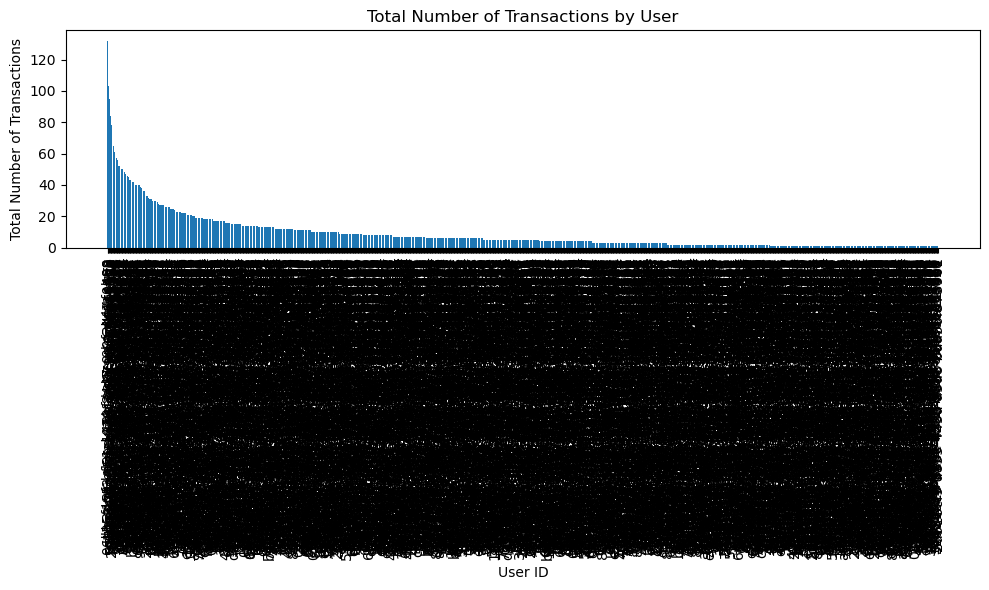

In [71]:
#visualize the graph for total No of transactions done by each user 
user_transaction_counts = data['USER_ID'].value_counts()


plt.figure(figsize=(10, 6))
plt.bar(user_transaction_counts.index, user_transaction_counts.values)
plt.xlabel('User ID')
plt.ylabel('Total Number of Transactions')
plt.title('Total Number of Transactions by User')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [72]:

user_yearly_transaction_count = data.groupby(['Year', 'USER_ID'])['TRANSACTION_ID'].count()


users_with_more_than_20_transactions = user_yearly_transaction_count[user_yearly_transaction_count > 20].reset_index()['USER_ID'].nunique()

print(f"Total number of users with more than 20 transactions in a year: {users_with_more_than_20_transactions}")

Total number of users with more than 20 transactions in a year: 112


In [73]:
user_transaction_periods = data.groupby('USER_ID')['CREATED_DATE'].agg(['min', 'max'])


user_transaction_periods['Days_In_Interval'] = (user_transaction_periods['max'] - user_transaction_periods['min']).dt.days.fillna(1)

print(user_transaction_periods[['Days_In_Interval']])

                                      Days_In_Interval
USER_ID                                               
00a2e510-355c-4f46-898c-4155e327ccf3                92
00a98617-0d8e-45d8-bca0-b67fe5d3471d               297
014b3a6c-5341-4620-ab9d-91ea69907c51               220
0169a613-81c2-44d9-a90e-39e3cab34380                24
017b6b45-9070-4d63-a191-70199c08ed37                 0
...                                                ...
ff04cdba-42cc-4b9d-a619-8d166957160f                 0
ff4d089f-5940-43e6-8eed-cfa7c3a0875b                 0
ff822972-1969-4f22-a711-72f603f901c6                 5
ff861ba2-d984-47ae-95a1-5fe143e0710c               157
ffc8a89d-8e53-4066-b622-36a60e2e9983                40

[1134 rows x 1 columns]


In [74]:
user_date_ranges = data.groupby('USER_ID')['CREATED_DATE'].agg(['min', 'max'])


user_date_ranges['duration_months'] = (user_date_ranges['max'] - user_date_ranges['min']) / pd.Timedelta(days=30)

users_lasted_6_months = user_date_ranges[user_date_ranges['duration_months'] > 6].shape[0]

print("Total Number of Users Lasted for More Than 6 Months:", users_lasted_6_months)

Total Number of Users Lasted for More Than 6 Months: 200


In [75]:
customer_total_spending = data.groupby('USER_ID')['AMOUNT'].sum()


sorted_customers_by_spending = customer_total_spending.sort_values(ascending=False)

for customer, spending in sorted_customers_by_spending.items():
    print(f"Customer: {customer}, Total Spending: {spending:.2f}")

Customer: 06bb2d68-bf61-4030-8447-9de64d3ce490, Total Spending: 22057.20
Customer: d35f19f3-d9ad-48bf-bd1e-90f3ba4f0b98, Total Spending: 18345.98
Customer: d1bc3cd6-154e-479f-8957-a69cdf414462, Total Spending: 16684.73
Customer: 65ac0928-e17d-4636-96f4-ebe6bdb9c98d, Total Spending: 15261.73
Customer: 59d3efe9-135b-4b44-ac59-80a13da8109a, Total Spending: 15083.93
Customer: 0fe472c9-cf3e-4e43-90f3-a0cfb6a4f1f0, Total Spending: 14450.34
Customer: 20100a1d-12bc-41ed-a5e1-bc46216e9696, Total Spending: 14291.30
Customer: 84e22e7f-f2ab-413c-969a-667c78d8885c, Total Spending: 14098.60
Customer: 26e8432c-5fdb-4b67-82e6-18f341d511a1, Total Spending: 11036.51
Customer: 6cae3eb6-515c-4811-8b51-32fb2e95da28, Total Spending: 10937.53
Customer: 74fdc60d-ee12-47c1-85f0-1c7dd1dbbf16, Total Spending: 9948.67
Customer: 87a390af-2f35-40ec-a111-16d43fc5a3e3, Total Spending: 9808.44
Customer: f54baeeb-7282-4d23-9bb7-e8396ce1b159, Total Spending: 9754.22
Customer: 9e988c5b-71d0-4f3e-8f81-b3c30aa9c240, Total 

<Figure size 1000x600 with 0 Axes>

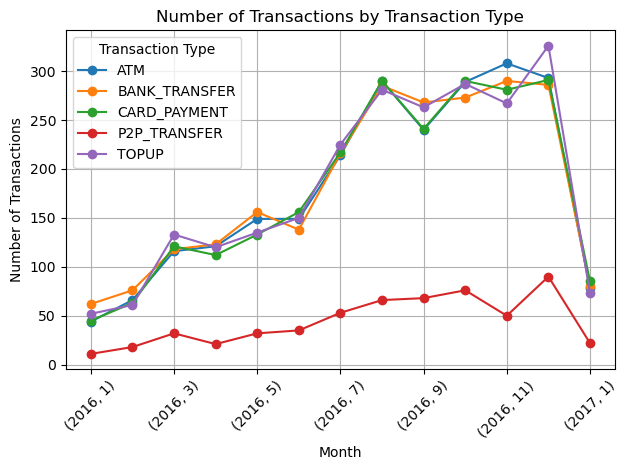

In [76]:
data['Month'] = data['CREATED_DATE'].dt.month
data['Year'] = data['CREATED_DATE'].dt.year


transaction_types = ['P2P_TRANSFER', 'ATM', 'CARD_PAYMENT', 'BANK_TRANSFER', 'TOPUP']
filtered_data = data[data['TYPE'].isin(transaction_types)]


transaction_counts = filtered_data.groupby(['Year', 'Month', 'TYPE'])['TRANSACTION_ID'].count().reset_index()


pivot_table = transaction_counts.pivot_table(index=['Year', 'Month'], columns='TYPE', values='TRANSACTION_ID', fill_value=0)

plt.figure(figsize=(10, 6))
pivot_table.plot(kind='line', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Transaction Type')
plt.xticks(rotation=45)
plt.legend(title='Transaction Type')
plt.grid(True)
plt.tight_layout()
plt.show()

<Figure size 1000x600 with 0 Axes>

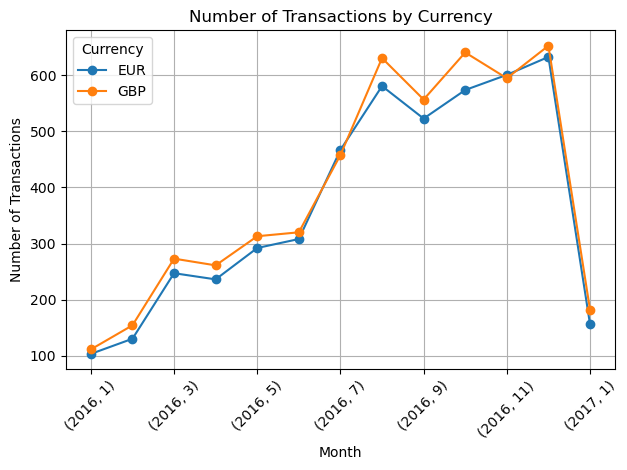

In [77]:
data['Month'] = data['CREATED_DATE'].dt.month
data['Year'] = data['CREATED_DATE'].dt.year


currency_types = ['EUR', 'GBP']
filtered_data = data[data['CURRENCY'].isin(currency_types)]


transaction_counts = filtered_data.groupby(['Year', 'Month', 'CURRENCY'])['TRANSACTION_ID'].count().reset_index()


pivot_table = transaction_counts.pivot_table(index=['Year', 'Month'], columns='CURRENCY', values='TRANSACTION_ID', fill_value=0)


plt.figure(figsize=(10, 6))
pivot_table.plot(kind='line', marker='o')
plt.xlabel('Month')
plt.ylabel('Number of Transactions')
plt.title('Number of Transactions by Currency')
plt.xticks(rotation=45)
plt.legend(title='Currency')
plt.grid(True)
plt.tight_layout()
plt.show()

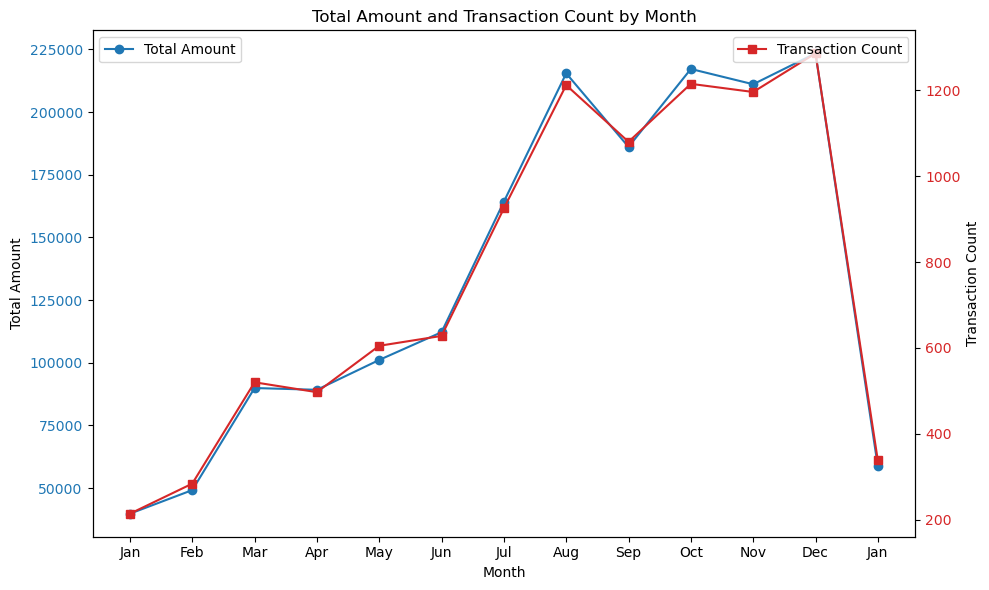

In [78]:

data['Month'] = data['CREATED_DATE'].dt.month
data['Year'] = data['CREATED_DATE'].dt.year


monthly_summary = data.groupby(['Year', 'Month']).agg({'AMOUNT': 'sum', 'TRANSACTION_ID': 'count'}).reset_index()


fig, ax1 = plt.subplots(figsize=(10, 6))


ax1.plot(monthly_summary.index, monthly_summary['AMOUNT'], color='tab:blue', marker='o', label='Total Amount')
ax1.set_xlabel('Month')
ax1.set_ylabel('Total Amount')
ax1.tick_params(axis='y', labelcolor='tab:blue')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()
ax2.plot(monthly_summary.index, monthly_summary['TRANSACTION_ID'], color='tab:red', marker='s', label='Transaction Count')
ax2.set_ylabel('Transaction Count')
ax2.tick_params(axis='y', labelcolor='tab:red')
ax2.legend(loc='upper right')


month_names = [pd.Timestamp(2000, i, 1).strftime('%b') for i in monthly_summary['Month']]
plt.xticks(monthly_summary.index, month_names)

plt.title('Total Amount and Transaction Count by Month')
plt.tight_layout()
plt.show()

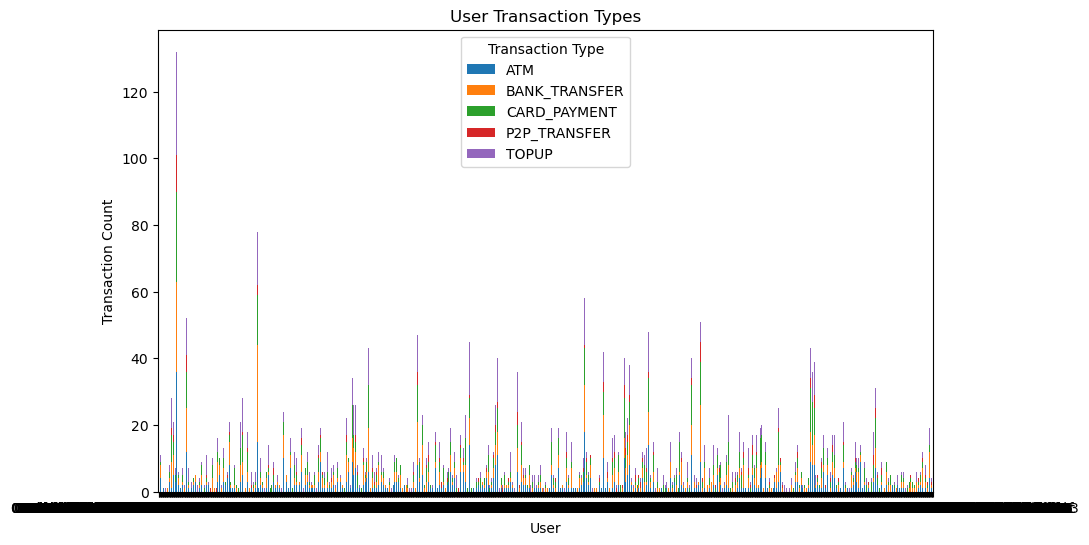

In [79]:
user_transaction_counts = data.groupby(['USER_ID', 'TYPE'])['TRANSACTION_ID'].count().unstack(fill_value=0)


user_transaction_counts.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.xlabel('User')
plt.ylabel('Transaction Count')
plt.title('User Transaction Types')
plt.legend(title='Transaction Type')
plt.xticks(rotation=0)
plt.show()

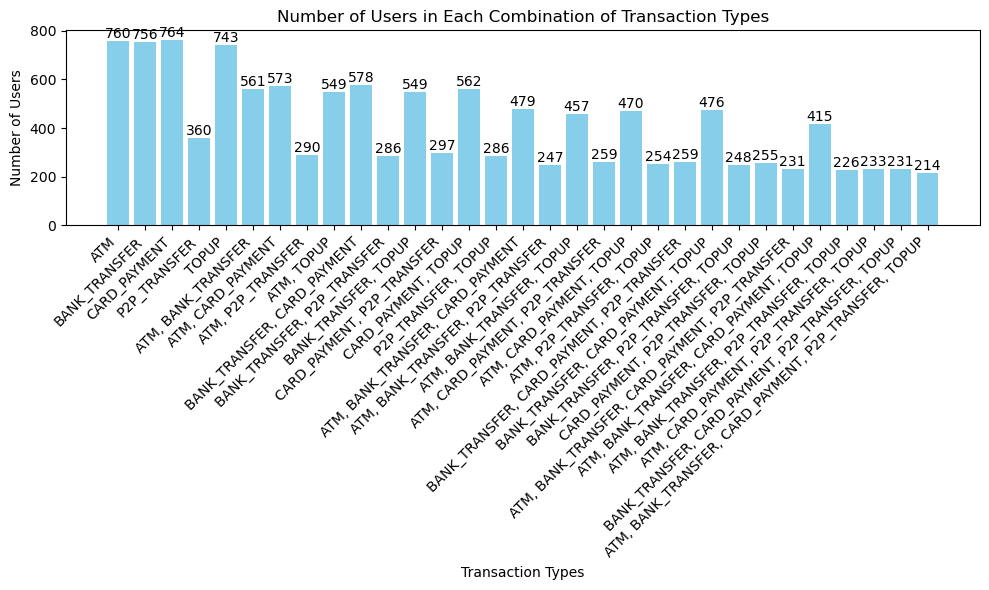

In [80]:
unique_users_by_type = data.groupby('TYPE')['USER_ID'].unique()


combinations_list = []
for r in range(1, len(unique_users_by_type) + 1):
    combinations_list.extend(combinations(unique_users_by_type.index, r))

combination_counts = Counter()
for combination in combinations_list:
    users = set(unique_users_by_type[combination[0]])
    for transaction_type in combination[1:]:
        users &= set(unique_users_by_type[transaction_type])
    combination_counts[combination] = len(users)


table_data = []
for combination, count in combination_counts.items():
    table_data.append({'Transaction Types': ', '.join(combination), 'Number of Users': count})


combination_df = pd.DataFrame(table_data)


plt.figure(figsize=(10, 6))
bars = plt.bar(combination_df['Transaction Types'], combination_df['Number of Users'], color='skyblue')
plt.xlabel('Transaction Types')
plt.ylabel('Number of Users')
plt.title('Number of Users in Each Combination of Transaction Types')
plt.xticks(rotation=45, ha='right')

for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom')

plt.tight_layout()
plt.show()